In [25]:
# ==============================
# Cell 1 : Librairies
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

sns.set(style="whitegrid")  # style graphique

In [26]:
# ==============================
# Cell 2 : Charger les données Silver
# ==============================
file_path = "/home/mountah_lodia/ecommerce_project/ecommerce_project/data/silver/cleaned_ecommerce_data.parquet"
df = pd.read_parquet(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,line_total,is_return
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34,False


In [30]:
# ==============================
# Cell 3 : Créer les features RFM et churn
# ==============================
last_date = pd.to_datetime(df['InvoiceDate']).max()

df_rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (last_date - pd.to_datetime(x.max())).days,
    "InvoiceNo": "count",
    "line_total": "sum",
    "Quantity": "sum",
    "UnitPrice": "mean"
}).rename(columns={
    "InvoiceDate": "recency_days",
    "InvoiceNo": "frequency",
    "line_total": "monetary",
    "Quantity": "total_items",
    "UnitPrice": "avg_price"
}).reset_index()

# Définir churn = 1 si dernier achat > 90 jours
df_rfm['churn'] = (df_rfm['recency_days'] > 90).astype(int)
df_rfm.head()

,CustomerID,recency_days,frequency,monetary,total_items,avg_price,churn
0,12346,325,1,77183.60,74215,1.040000,1
1,12347,2,182,4310.00,2458,2.644011,0
2,12348,75,31,1797.24,2341,5.764839,0
3,12349,18,73,1757.55,631,8.289041,0
4,12350,310,17,334.40,197,3.841176,1


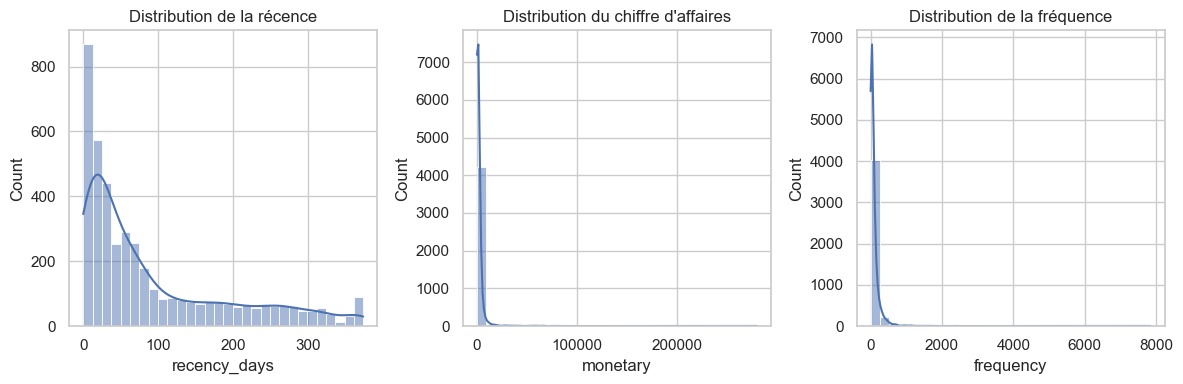

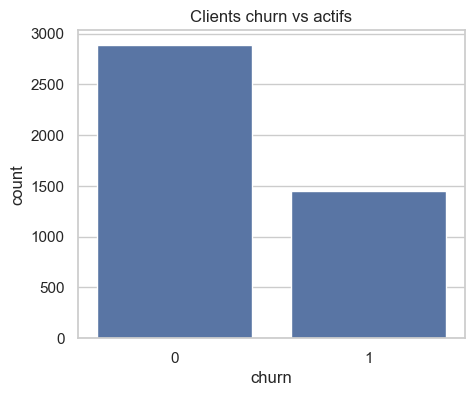

In [31]:
# ==============================
# Cell 4 : Visualisations exploratoires
# ==============================
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(df_rfm['recency_days'], bins=30, kde=True)
plt.title("Distribution de la récence")

plt.subplot(1,3,2)
sns.histplot(df_rfm['monetary'], bins=30, kde=True)
plt.title("Distribution du chiffre d'affaires")

plt.subplot(1,3,3)
sns.histplot(df_rfm['frequency'], bins=30, kde=True)
plt.title("Distribution de la fréquence")

plt.tight_layout()
plt.show()

# Churn
plt.figure(figsize=(5,4))
sns.countplot(x='churn', data=df_rfm)
plt.title("Clients churn vs actifs")
plt.show()

In [32]:
# ==============================
# Cell 5 : Préparation des données
# ==============================
features = ['recency_days', 'frequency', 'monetary', 'total_items', 'avg_price']
X = df_rfm[features]
y = df_rfm['churn']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# ==============================
# Cell 6 : Entraînement du Random Forest
# ==============================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           1       1.00      1.00      1.00       307

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



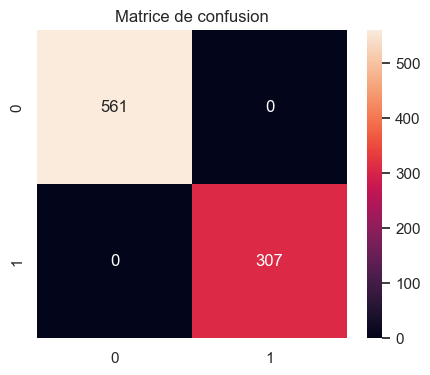

In [ ]:
# ==============================
# Cell 7 : Évaluation du modèle
# ==============================
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Matrice de confusion")
plt.show()




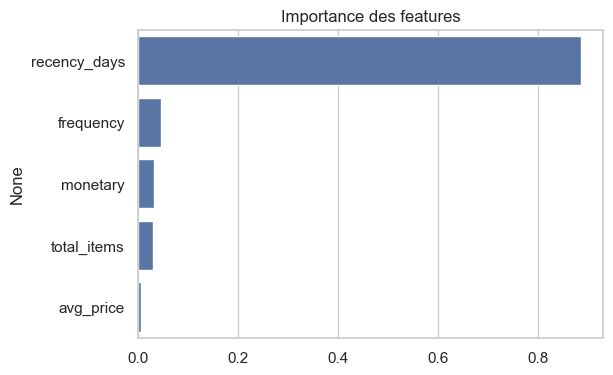

In [37]:
# Importance des features
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Importance des features")
plt.show()



In [38]:
# ==============================
# Cell 8 : Sauvegarde du modèle et du scaler
# ==============================
model_dir = "/home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model"
os.makedirs(model_dir, exist_ok=True)

In [39]:
# Sauvegarder le scaler
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler sauvegardé ici : {scaler_path}")

# Sauvegarder le modèle Random Forest
model_path = os.path.join(model_dir, "random_forest_churn.pkl")
joblib.dump(model, model_path)
print(f"✅ Modèle Random Forest sauvegardé ici : {model_path}")

✅ Scaler sauvegardé ici : /home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model\scaler.pkl
✅ Modèle Random Forest sauvegardé ici : /home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model\random_forest_churn.pkl
